In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive

import pickle


**Load the data from Drive**

In [ ]:
with open('/content/drive/MyDrive/DL/DL Project 2/DS_5_train_input', 'rb') as f:
    data_input = pickle.load(f)
    
with open('/content/drive/MyDrive/DL/DL Project 2/DS_5_train_output', 'rb') as f:
    data_output = pickle.load(f)

with open('/content/drive/MyDrive/DL/DL Project 2/DS_5_test_input', 'rb') as f:
    test_texts = pickle.load(f)

**Create pairs and for the output or second language add start and end indexes**

In [ ]:
text_pairs = []
i = 0
for string in data_output:
  data_output[i] = "[start] " + string + " [end]"
  text_pairs.append((data_input[i], data_output[i]))
  i=i+1

**Create required pairs for training, validation and testing**

In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

test_pairs_testing=test_pairs

**Text Vectorization**

In [ ]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 1000
sequence_length = 35

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

**Define a new definition for making dataset and perform the following steps**

In [ ]:
batch_size = 64

def format_dataset(input, output):
    input = source_vectorization(input)
    output = target_vectorization(output)
    return ({
        "inputLang": input,
        "outputLang": output[:, :-1],
    }, output[:, 1:])

def make_dataset(pairs):
    input_texts, output_texts = zip(*pairs)
    input_texts = list(input_texts)
    output_texts = list(output_texts)
    dataset = tf.data.Dataset.from_tensor_slices((input_texts, output_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

**Check Shapes for dataset**

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['inputLang'].shape: {inputs['inputLang'].shape}")
    print(f"inputs['outputLang'].shape: {inputs['outputLang'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['inputLang'].shape: (64, 35)
inputs['outputLang'].shape: (64, 35)
targets.shape: (64, 35)


**Create Model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="inputLang")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="outputLang")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)
models2s_rnn = keras.Model([source, past_target], target_next_step)


In [ ]:
models2s_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = models2s_rnn.fit(train_ds, epochs=101, validation_data=val_ds)

# Print train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print('Training accuracy:', train_acc[-1])
print('Validation accuracy:', val_acc[-1])


models2s_rnn.save('/content/drive/MyDrive/DL/DL Project 2/Sushant/modelproject2_epochs101.h5')




Epoch 1/101
55/55 [==============================] - 20s 133ms/step - loss: 3.0876 - accuracy: 0.1555 - val_loss: 2.1139 - val_accuracy: 0.2544
Epoch 2/101
55/55 [==============================] - 4s 65ms/step - loss: 1.9064 - accuracy: 0.2528 - val_loss: 1.6271 - val_accuracy: 0.3208
Epoch 3/101
55/55 [==============================] - 4s 65ms/step - loss: 1.6245 - accuracy: 0.3044 - val_loss: 1.4905 - val_accuracy: 0.3582
Epoch 4/101
55/55 [==============================] - 4s 65ms/step - loss: 1.5131 - accuracy: 0.3351 - val_loss: 1.4323 - val_accuracy: 0.3637
Epoch 5/101
55/55 [==============================] - 4s 65ms/step - loss: 1.4290 - accuracy: 0.3558 - val_loss: 1.3503 - val_accuracy: 0.3799
Epoch 6/101
55/55 [==============================] - 4s 65ms/step - loss: 1.3659 - accuracy: 0.3717 - val_loss: 1.2966 - val_accuracy: 0.3953
Epoch 7/101
55/55 [==============================] - 4s 66ms/step - loss: 1.3154 - accuracy: 0.3867 - val_loss: 1.2842 - val_accuracy: 0.3939
Epoc

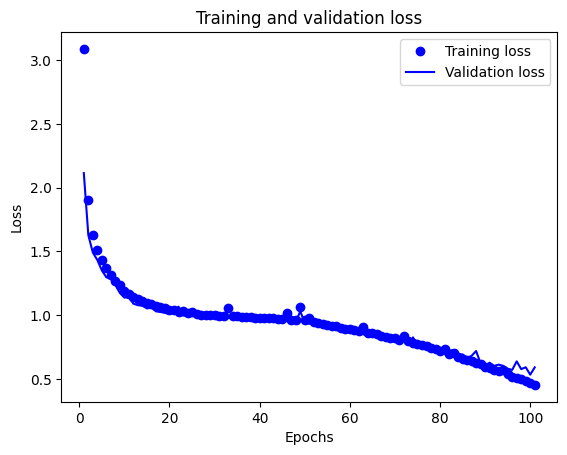

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
models2s_rnn = keras.models.load_model("/content/drive/MyDrive/DL/DL Project 2/Sushant/modelproject2_epochs101.h5")

**Test data from training dataset**


In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 35

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = models2s_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[7:len(decoded_sentence)-5]

test_eng_texts = [pair[0] for pair in test_pairs]

mylist = []
for i in range(5):
    input_sentence = test_eng_texts[i]
    print("input:",input_sentence)
    mylist.append(decode_sequence(input_sentence))
    print("ouput:",decode_sequence(input_sentence))

# pickle.dump(mylist, open(
#   # "/content/drive/MyDrive/DL/traintest",'wb'))

input: a f a k b d c f a d a h a k b d b f a f b d b f a h b e c f a i b g a e b g a f a f c f b g a k b g c f c d 
1/1 [==============================] - 0s 31ms/step
ouput:  b d c f a d d e b d b f b d a f h i b f a e k b g c f a k m ed b 
input: a h a e a f a i a k a j c e a h a f c f c g b e a f b g b g b d a e b d b e c d a f c e b e c e c d 
1/1 [==============================] - 0s 31ms/step
ouput:  c e c f c e a g e f c g b f a j g h i b g a e k a g j l b g a d m
input: a d a k a d a i b f c f b e a i a j b g b d a k a e c f a f c g b f a k a j c d b d b f b g c d b d a f c g a k a e c e b e 
1/1 [==============================] - 0s 30ms/step
ouput:  b f c f b e a j d e f b d b g a g h i c f c d a e l a k k m c f 
input: a f a d a i c d a d c e a g c e a k a j a i b g a j c e c e c f b e a k b f a d c f b e a g b g b d b f a f c g c d c g c g 
1/1 [==============================] - 0s 32ms/step
ouput:  c d c e c e b g c e c e c f a g i j b e c g a j k l m a d h ed a e
input: a

In [ ]:
print(mylist)

[' b d c f a d d e b d b f b d a f h i b f a e k b g c f a k m ed b ', ' c e c f c e a g e f c g b f a j g h i b g a e k a g j l b g a d m', ' b f c f b e a j d e f b d b g a g h i c f c d a e l a k k m c f ', ' c d c e c e b g c e c e c f a g i j b e c g a j k l m a d h ed a e', ' c f b e c f c d a e g a f f h a k e i a e j b g a f k l c g a e e']


In [ ]:
# print(test_pairs_testing)
test_eng_texts = [pair[1] for pair in test_pairs]
# print(test_eng_texts[1])
test_eng_texts_ = [pair[0] for pair in test_pairs]
for i in range(len(test_eng_texts)):
  if test_eng_texts_[i] == "a h a e a f a i a k a j c e a h a f c f c g b e a f b g b g b d a e b d b e c d a f c e b e c e c d ":
    print(test_eng_texts[i])


[start] c e c f c g a f e f b e b g b g a f i j a h g h k b d a j d l m b d a e ee a k ed ef b e c d a i eg eh ei c e b e a f ek el a f ej em a e fd c e c d a h fe ff fg  [end]


**Running Actual Test Data of 5000 texts**

In [ ]:
import numpy as np
output_vocab = target_vectorization.get_vocabulary()
output_index_lookup = dict(zip(range(len(output_vocab)), output_vocab))
max_decoded_sentence_length = 35

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = models2s_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = output_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[7:len(decoded_sentence)-5]

test_texts = [pair for pair in test_texts]
# test_texts
testList = []

for i in range(len(test_texts)):
    input_sentence = test_texts[i]
    testList.append(decode_sequence(input_sentence))
# for i in range(len(testList)):
#   print(testList[i])

pickle.dump(testList, open(
  "/content/drive/MyDrive/DL/DL Project 2/Sushant/ActualTestDataOutputList.pkl",'wb'))

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step


In [ ]:
for i in range(2500,2505):
  print(testList[i])

 b e b e a e e b e a e f c e b f a h j i h a d d k a e l b d a e e
 b e c g c d a e d a f e f a e j c d a f i h c f c g b d b f a g ed
 b g a e g b g b g a g d f b g c d a e h a e k a k i l b d a g m e
 c f c g c d a g e d b g a g f j c g a f i h a g g k c f b g a d m
 c g b e a g g e c e a e f b f c d a e h a e k a f i l a e m a g j


**Finding Testing Accuracy on Test data from training data**

In [ ]:
test_ds = make_dataset(test_pairs)
model = keras.models.load_model("/content/drive/MyDrive/DL/DL Project 2/Sushant/modelproject2_epochs101.h5")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

12/12 [==============================] - 4s 29ms/step - loss: 0.5951 - accuracy: 0.7665
Test accuracy: 0.766
